In [1]:
from os import listdir
from os.path import isfile, join
# Import Packages and setup
import numpy as np
import scarlet
import scarlet.display
import astropy.io.fits as fits
from astropy.wcs import WCS
from scarlet.display import AsinhMapping
from scarlet import Starlet
from scarlet.wavelet import mad_wavelet
import scipy.stats as scs
from scarlet.initialization import build_initialization_coadd
from functools import partial
import collections
from scarlet_extensions.initialization.detection import makeCatalog, Data
import sep
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gist_stern')
matplotlib.rc('image', interpolation='none')
from astropy.nddata import Cutout2D
import warnings
warnings.simplefilter("ignore")

In [2]:
# First we load the data and organise them as a cube
path = '/Users/remy/Desktop/git_repos/LSBG_wavelets/Data/'


#So far the only values of i that work are 6, 7, 12, 14, 15, 17, 18, 19, 22, 25
i = '6' #Only psfs available
bands = ['G', 'R', 'I', 'Z', 'Y']

cube = []
psfs = []
for b in bands:
    file = [f for f in listdir(path+'HSC_'+b) if (f[0] == i or f[:2] == i)][0]
    if i in ['6','18']:
        ipsf = i
    else:
        ipsf = '6' #Use the psf for image 6 if no psf exists
    psf_file = [f for f in listdir(path+'psf-'+b) if (f[0] == ipsf or f[:2] == ipsf)][0]
    
    hdu_HSC = fits.open(path+'HSC_'+b+'/'+file)
    hdu_PSF = fits.open(path+'psf-'+b+'/'+psf_file)
    
    psf = hdu_PSF[0].data
    if np.shape(psf)[0] != 41:
        psf = psf[1:-1,:]
    if np.shape(psf)[1] != 41:
        psf = psf[:,1:-1]
    
    cube.append(hdu_HSC[1].data)
    psfs.append(psf)
    
wcs = WCS(hdu_HSC[1].header)
#hdus = fits.PrimaryHDU(np.array(cube), header = hdu_HSC[1].header)
#lists = fits.HDUList([hdus])
#lists.writeto(F'{i}_hsc_cube.fits', clobber=True)

#hdus = fits.PrimaryHDU(np.array(psfs), header = hdu_PSF[0].header)
#lists = fits.HDUList([hdus])
#lists.writeto(F'{i}_hsc_psfs.fits', clobber=True)

cube = np.array(cube)
psfs = np.array(psfs)
channels = ['g','r','i','z','y']

data = {
    "images": cube, 
    "psfs":psfs,
    "wcs":wcs,
    "channels": channels}
print(cube.shape)
nc,nx,ny = np.shape(cube)

import pickle
fr = open("./lsbg.pkl","wb")
pickle.dump(data, fr)
fr.close()

(5, 191, 191)


In [3]:
def makeCatalog(datas, lvl=3, wave=True):
    ''' Creates a detection catalog by combining low and high resolution data
    Parameters
    ----------
    datas: array
        array of Data objects
    lvl: int
        detection lvl
    wave: Bool
        set to True to use wavelet decomposition of images before combination
    Returns
    -------
    catalog: sextractor catalog
        catalog of detected sources
    bg_rms: array
        background level for each data set
    '''
    if type(datas) is np.ndarray:
        hr_images = datas / np.sum(datas, axis=(1, 2))[:, None, None]
        # Detection image as the sum over all images
        detect_image = np.sum(hr_images, axis=0)
    else:
        data_lr, data_hr = datas
        # Create observations for each image
        # Interpolate low resolution to high resolution
        interp = interpolate(data_lr, data_hr)
        # Normalisation of the interpolate low res images
        interp = interp / np.sum(interp, axis=(1, 2))[:, None, None]
        # Normalisation of the high res data
        hr_images = data_hr.images / np.sum(data_hr.images, axis=(1, 2))[:, None, None]
        # Detection image as the sum over all images
        detect_image = np.sum(interp, axis=0) + np.sum(hr_images, axis=0)
        detect_image *= np.sum(data_hr.images)
    if np.size(detect_image.shape) == 3:
        if wave:
            # Wavelet detection in the first three levels
            wave_detect = Starlet(detect_image.mean(axis=0), lvl=4).coefficients
            wave_detect[:, -1, :, :] = 0
            detect = scarlet.Starlet(coefficients=wave_detect).image
        else:
            # Direct detection
            detect = detect_image.mean(axis=0)
    else:
        if wave:
            wave_detect = scarlet.Starlet(detect_image).coefficients
            detect = wave_detect[0][0] + wave_detect[0][1] + wave_detect[0][2]
        else:
            detect = detect_image

    bkg = sep.Background(detect)
    catalog = sep.extract(detect, lvl, err=bkg.globalrms)

    if type(datas) is np.ndarray:
        bg_rms = scarlet.wavelet.mad_wavelet(datas)
    else:
        bg_rms = []
        for data in datas:
            bg_rms.append(scarlet.wavelet.mad_wavelet(data.images))

    return catalog, bg_rms

In [4]:
#Detection step. we identify all the source that we have to model.
wave = True #True means wavelet detection. False is regular detection with sep. True is advised in this specific case

if i in ['6', '7']:
    lvl = 4 #Level detection in multiples of noise levels. 
else:
    lvl = 2
#Lower to get more faint sources. For source '6' and '7', lvl=4 is good, but for most other sources (25 for instance) you need to go down to 2 if you want to pick on the faint blended blobs

catalog, bg_rms_hsc = makeCatalog(cube, 1.5, wave)

weights = np.ones_like(cube) / (bg_rms_hsc**2)[:, None, None]

No handles with labels found to put in legend.


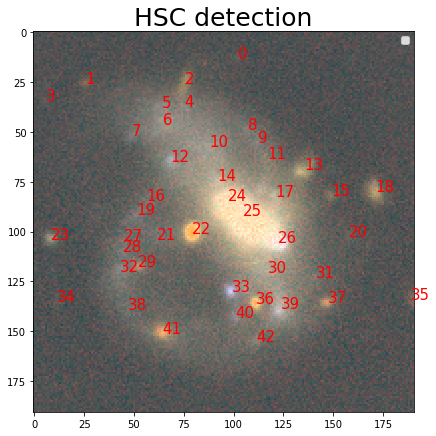

In [5]:
# Create a color mapping for the HSC image
hsc_norm = AsinhMapping(minimum=-1, stretch=3, Q=1)

# Get the source coordinates from the HST catalog
pixel_hsc = np.stack((catalog['y'], catalog['x']), axis=1)

# Convert the HST coordinates to the HSC WCS
# Map the HSC image to RGB
img_rgb = scarlet.display.img_to_rgb(cube, norm=hsc_norm)

plt.figure(figsize=(21,7))

plt.imshow(img_rgb)
#plt.axis('off')

for k,p in enumerate(pixel_hsc):
    plt.text(p[1], p[0], str(k), color="r", fontsize = 15)
#plt.plot(pixel_hsc[1], pixel_hsc[0], 'xr', label = 'HSC detection')
plt.legend()
plt.title("HSC detection", fontsize = 25)

plt.show()

In [6]:
model_psf = scarlet.GaussianPSF(sigma = 0.8)

model_frame = scarlet.Frame(
    cube.shape,
    psfs=model_psf,
    channels=channels)

observation = scarlet.Observation(
    cube, 
    psfs=scarlet.ImagePSF(psfs), 
    weights=weights, 
    channels=channels).match(model_frame)

In [7]:
#Display function
def display_init(blend, obs, data, ids, img, title, save = False):
    # Load the model and calculate the residual
    model = blend.get_model()
    model = obs.render(model)
    
    init_rgb = scarlet.display.img_to_rgb(model, norm=hsc_norm)
    residual = data - model
    
    residual_rgb = scarlet.display.img_to_rgb(residual[:,:])
    vmax = np.max(np.abs(residual_rgb))
    if residual_rgb.shape[0]<2:
        residual_rgb = residual_rgb[0,:,:]
        print('zizi')
    plt.figure(ids,figsize=(20, 8))
    plt.suptitle(title, fontsize=36)
    plt.subplot(131)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Data", fontsize=20)
    plt.subplot(132)
    plt.imshow(init_rgb)
    plt.axis('off')
    plt.title("Model", fontsize=20)
    plt.subplot(133)
    plt.imshow(residual_rgb, vmin=-vmax, vmax=vmax, cmap = 'seismic')
    plt.axis('off')
    plt.title("Residuals", fontsize=20)
    if save is True:
        plt.savefig(title+'_'+str(coord[0])+'_'+str(coord[1])+'.png')
    pass

In [8]:
starlet_sources = []
for k,src in enumerate(catalog):
    new_source = scarlet.ExtendedSource(model_frame, 
                                        (src['y'], src['x']), 
                                        observation, 
                                        K=1, compact = True)
    starlet_sources.append(new_source)
 

new_source = scarlet.StarletSource(model_frame, 
                        (nx/2, ny/2), observation, 
                        starlet_thresh = 1)
starlet_sources.append(new_source)  

CPU times: user 39.6 s, sys: 5.37 s, total: 45 s
Wall time: 45 s
scarlet ran for 186 iterations to logL = 178745.25077775534


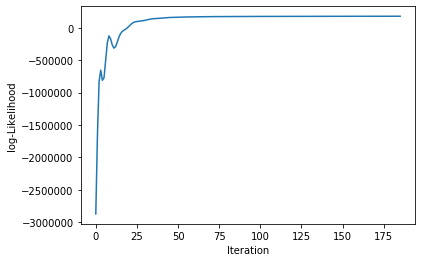

In [9]:
starlet_blend = scarlet.Blend(starlet_sources, observation)
%time it, logL = starlet_blend.fit(200, e_rel=1e-4)
print(f"scarlet ran for {it} iterations to logL = {logL}")
scarlet.display.show_likelihood(starlet_blend)
plt.show()

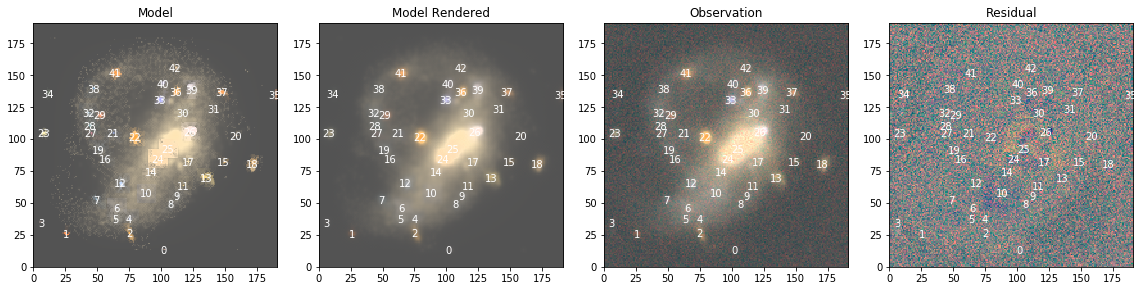

In [10]:
scarlet.display.show_scene(starlet_sources, 
                           norm=hsc_norm, 
                           observation=observation, 
                           show_rendered=True, 
                           show_observed=True, 
                           show_residual=True,
                          )
plt.show()

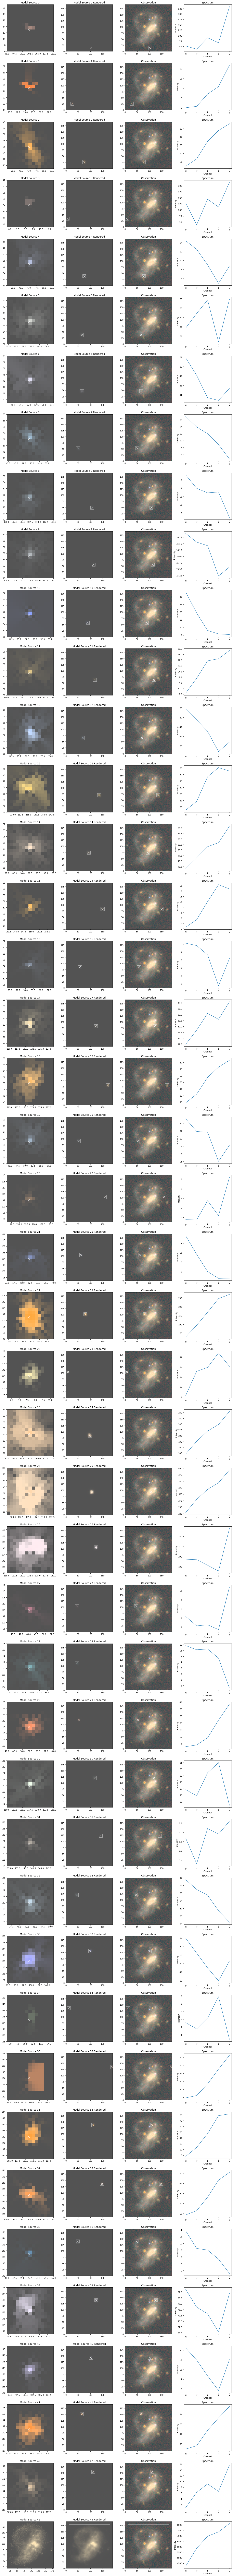

In [11]:
scarlet.display.show_sources(starlet_sources, 
                             norm=hsc_norm, 
                             observation=observation,
                             show_rendered=True, 
                             show_observed=True,
                             add_boxes=True
                            )
plt.show()

(-0.5, 190.5, 190.5, -0.5)

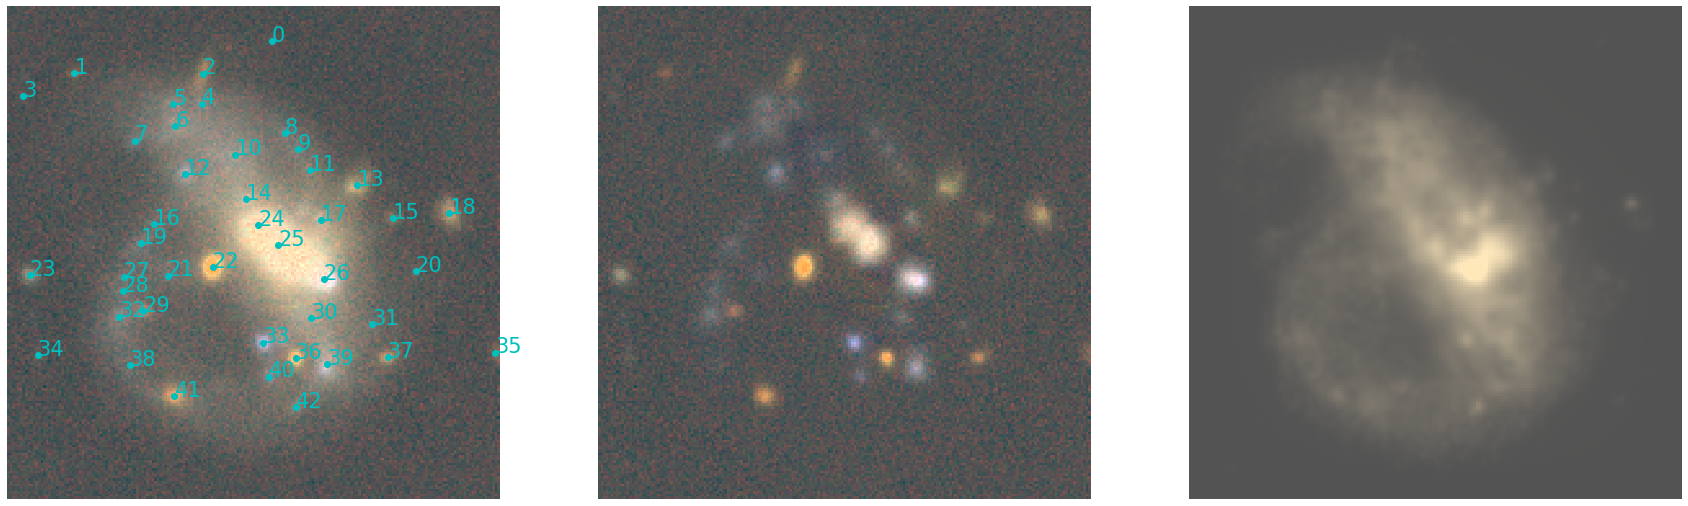

In [12]:
lsbg = starlet_sources[-2].get_model(frame=model_frame)+starlet_sources[-1].get_model(frame=model_frame)
model = 0

lsbg = observation.render(lsbg)
res_rgb = scarlet.display.img_to_rgb(cube-lsbg, norm=hsc_norm)
img_rgb = scarlet.display.img_to_rgb(cube, norm=hsc_norm)
lsbg_rgb = scarlet.display.img_to_rgb(lsbg, norm=hsc_norm)

plt.figure(figsize = (30,15))
plt.subplot(131)
plt.imshow(img_rgb)
for k in range(len(catalog["x"])):
    plt.text(catalog["x"][k], catalog["y"][k], k, color = 'c', fontsize = 21)
plt.plot(catalog["x"], catalog["y"], 'co')
plt.axis("off")

plt.subplot(133)
plt.imshow(lsbg_rgb)
plt.axis("off")

plt.subplot(132)
plt.imshow(res_rgb)
plt.axis("off")